In [2]:
#!/usr/bin/python
import csv
import time
import json
import requests
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mpl_finance

In [3]:
headers = {'Content-Type': 'application/json'}
api_url_base = 'https://public.bitbank.cc'
pair = 'btc_jpy'
period = '1day'

day = "{0:%Y%m%d}".format(datetime.today())
year = "2018"

In [4]:
def api_ohlcv(timestamp):
    api_url = '{0}/{1}/candlestick/{2}/{3}'.format(api_url_base, pair, period, timestamp)
    response = requests.get(api_url, headers=headers)

    if response.status_code == 200:
        ohlcv = json.loads(response.content.decode('utf-8'))['data']['candlestick'][0]['ohlcv']
        return ohlcv
    else:
        return None

In [5]:
ohlcv = api_ohlcv(year)
open, high, low, close, volume, timestamp = [],[],[],[],[],[]
for i in ohlcv:
    open.append(int(i[0]))
    high.append(int(i[1]))
    low.append(int(i[2]))
    close.append(int(i[3]))
    volume.append(float(i[4]))
    time_str = str(i[5])
    timestamp.append(datetime.fromtimestamp(int(time_str[:10])).strftime('%Y/%m/%d %H:%M:%M'))

date_time_index = pd.to_datetime(timestamp) # convert to DateTimeIndex type
df = pd.DataFrame({'open': open, 'high': high, 'low': low, 'close': close}, index=date_time_index) # volume is not contained
# adjustment for JST if required
df.index += pd.offsets.Hour(9) # adjustment for JST

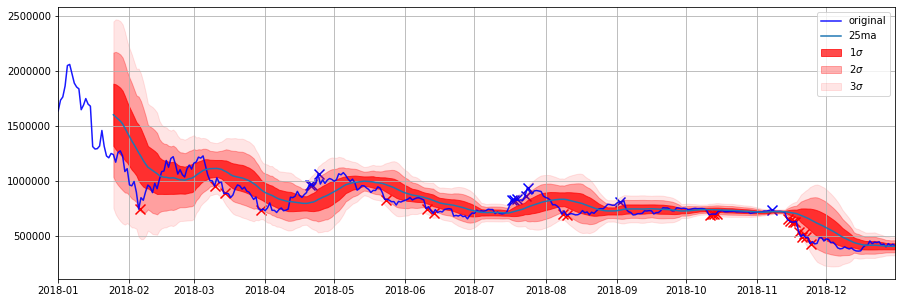

In [9]:
def Bollinger(df, window=25):
    df1 = df.copy()
    df1["ma"] = df1.close.rolling(window=window).mean()
    df1["sigma"] =  df1.close.rolling(window=window).std()
    df1["ma+2sigma"] = df1.ma + 2*df1.sigma
    df1["ma-2sigma"] = df1.ma - 2*df1.sigma
    df1["diffplus"] = df1.close - df1["ma+2sigma"] 
    df1["diffminus"] = df1["ma-2sigma"] - df1.close
    s_up = df1[df1["diffplus"] > 0]["close"]
    s_down = df1[df1["diffminus"] > 0]["close"]

    xdate = [x.date() for x in df1.index]
    plt.figure(figsize=(15,5))
    plt.grid()
    plt.xlim(xdate[0], xdate[-1])
    plt.scatter(s_up.index, s_up.values,marker="x", s=100, color="blue")
    plt.scatter(s_down.index, s_down.values,marker="x", s=100, color="red")
    plt.plot(xdate, df1.close.values, label="original", color="b", alpha=0.9)
    plt.plot(xdate, df1.ma.values, label="{}ma".format(window))
    plt.fill_between(xdate, df1.ma-df1.sigma, df1.ma+df1.sigma, color="red", alpha=0.7, label="$1\sigma$")
    plt.fill_between(xdate, df1.ma-2*df1.sigma, df1.ma+2*df1.sigma, color="red", alpha=0.3, label="$2\sigma$")
    plt.fill_between(xdate, df1.ma-3*df1.sigma, df1.ma+3*df1.sigma, color="red", alpha=0.1, label="$3\sigma$") 
    plt.legend()

Bollinger(df, window=25)

2018-05-05:GOLDEN CROSS
2018-06-01:DEAD CROSS
2018-07-28:GOLDEN CROSS
2018-08-22:DEAD CROSS
2018-10-15:GOLDEN CROSS
2018-10-22:DEAD CROSS


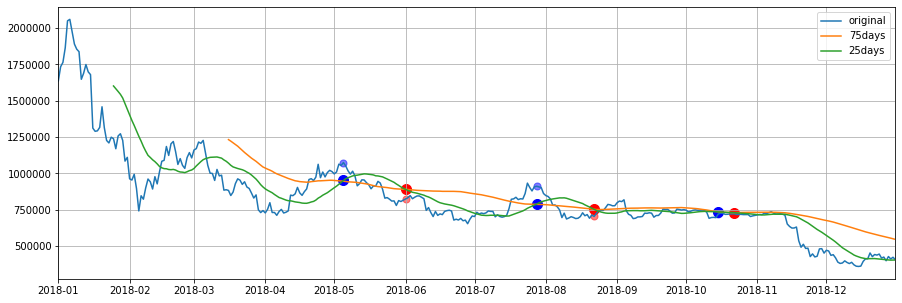

In [12]:
def SMA(df):
    df1 = df.copy()
    df1["ma25"] = df1.close.rolling(window=25).mean()
    df1["ma75"] = df1.close.rolling(window=75).mean()
    df1["diff"] = df1.ma25 - df1.ma75
    df1["unixtime"] = [datetime.timestamp(t) for t in df.index]

    # line and Moving Average
    xdate = [x.date() for x in df1.index]
    plt.figure(figsize=(15,5))
    plt.plot(xdate, df1.close,label="original")
    plt.plot(xdate, df1.ma75,label="75days")
    plt.plot(xdate, df1.ma25,label="25days")
    plt.xlim(xdate[0], xdate[-1])
    plt.grid()

    # Cross points
    for i in range(1, len(df1)):
        if df1.iloc[i-1]["diff"] < 0 and df1.iloc[i]["diff"] > 0:
            print("{}:GOLDEN CROSS".format(xdate[i]))
            plt.scatter(xdate[i], df1.iloc[i]["ma25"], marker="o", s=100, color="b")
            plt.scatter(xdate[i], df1.iloc[i]["close"], marker="o", s=50, color="b", alpha=0.5)

        if df1.iloc[i-1]["diff"] > 0 and df1.iloc[i]["diff"] < 0:
            print("{}:DEAD CROSS".format(xdate[i]))
            plt.scatter(xdate[i], df1.iloc[i]["ma25"], marker="o", s=100, color="r")
            plt.scatter(xdate[i], df1.iloc[i]["close"], marker="o", s=50, color="r", alpha=0.5)
    plt.legend()

SMA(df)

2018-01-01:DEAD CROSS
2018-01-01:GOLDEN CROSS
2018-01-01:DEAD CROSS
2018-01-01:GOLDEN CROSS
2018-01-01:DEAD CROSS
2018-01-01:GOLDEN CROSS
2018-01-01:DEAD CROSS
2018-01-01:GOLDEN CROSS
2018-01-01:DEAD CROSS
2018-01-01:GOLDEN CROSS
2018-01-01:DEAD CROSS
2018-01-01:GOLDEN CROSS
2018-01-01:DEAD CROSS
2018-01-01:GOLDEN CROSS
2018-01-01:DEAD CROSS
2018-01-01:GOLDEN CROSS
2018-01-01:DEAD CROSS
2018-01-01:GOLDEN CROSS
2018-01-01:DEAD CROSS
2018-01-01:GOLDEN CROSS
2018-01-01:DEAD CROSS
2018-01-01:GOLDEN CROSS
2018-01-01:DEAD CROSS
2018-01-01:GOLDEN CROSS


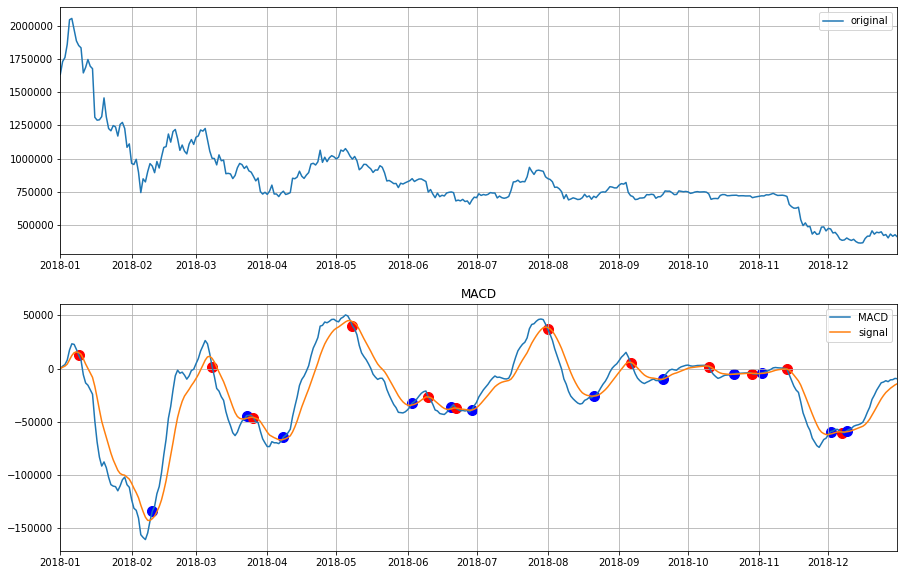

In [13]:
def MACD(df):
    df1 = df.copy()
    df1["MACD"] = df1.close.ewm(span=12, min_periods=1).mean() - df1.close.ewm(span=26, min_periods=1).mean()
    df1["signal"] = df1.MACD.ewm(span=9, min_periods=1).mean()
    df1["macd_diff"] = df1["MACD"] - df1["signal"]

    xdate = [x.date() for x in df1.index]
    plt.figure(figsize=(15,10))
    # plot the original
    plt.subplot(211)
    plt.plot(xdate, df1.close,label="original")
    plt.xlim(xdate[0], xdate[-1])
    plt.legend()
    plt.grid()
    # plot MACD
    plt.subplot(212)
    plt.title("MACD")
    plt.plot(xdate, df1.MACD, label="MACD")
    plt.plot(xdate, df1.signal, label="signal")
    plt.xlim(xdate[0], xdate[-1])
    plt.legend()
    plt.grid(True)

    # Cross points
    for i in range(1, len(df1)):
        if df1.iloc[i-1]["macd_diff"] < 0 and df1.iloc[i]["macd_diff"] > 0:
            print("{}:GOLDEN CROSS".format(xdate[0]))
            plt.scatter(xdate[i], df1.iloc[i]["MACD"], marker="o", s=100, color="b")

        if df1.iloc[i-1]["macd_diff"] > 0 and df1.iloc[i]["macd_diff"] < 0:
            print("{}:DEAD CROSS".format(xdate[0]))
            plt.scatter(xdate[i], df1.iloc[i]["MACD"], marker="o", s=100, color="r")
        
MACD(df)

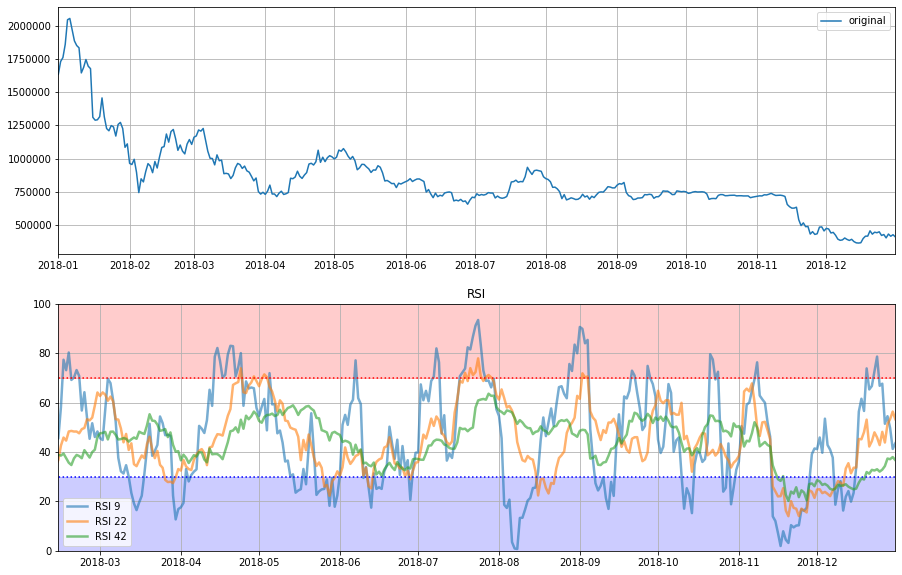

In [20]:
def plot_RSI(df, window):
    df1 = df.copy()
    diff = df1.close.diff(periods=1).values
    xdate = [x.date() for x in df1.index]
    RSI = []
    for i in range(window+1, len(xdate)):
        neg = 0
        pos = 0
        for value in diff[i-window:i+1]:
            if value > 0:
                pos += value
            if value < 0:
                neg += value
        pos_ave = pos/window
        neg_ave = np.abs(neg/window)
        rsi = pos_ave/(pos_ave+neg_ave)*100
        RSI.append(rsi)
    # draw RSI figure
    plt.plot(xdate[window+1:], RSI, label = "RSI {}".format(window), lw=2.5, alpha=0.6)
    plt.xlim(xdate[window+1], xdate[-1])
    plt.ylim(0,100)
    plt.legend()

def RSI(df):
    df1 = df.copy()
    xdate = [x.date() for x in df1.index]
    plt.figure(figsize=(15,10))
    # plot the original
    plt.subplot(211)
    plt.plot(xdate, df1.close,label="original")
    plt.xlim(xdate[0], xdate[-1])
    plt.legend()
    plt.grid()
    # plot RSI
    plt.subplot(212)
    plt.grid()
    plt.title("RSI")
    plot_RSI(df1, window=9)
    plot_RSI(df1, window=22)
    plot_RSI(df1, window=42)
    plt.fill_between(xdate, np.ones(len(xdate))*30, color="blue", alpha=0.2)
    plt.fill_between(xdate, np.ones(len(xdate))*70, np.ones(len(xdate))*100, color="red", alpha=0.2)
    plt.plot(xdate, np.ones(len(xdate))*30, color="blue", linestyle="dotted")
    plt.plot(xdate, np.ones(len(xdate))*70, color="red", linestyle="dotted")
    plt.show()
    
RSI(df)

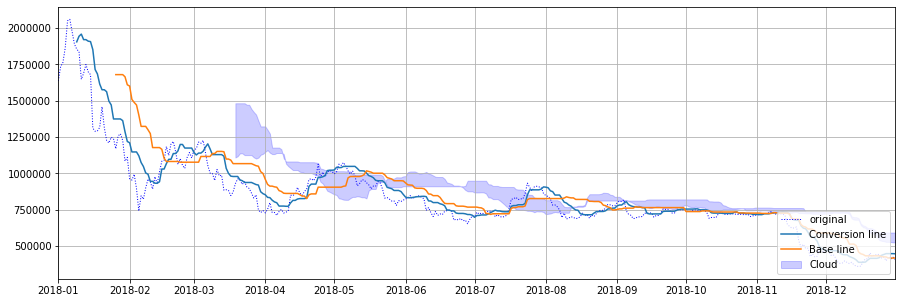

In [24]:
def Ichimoku(df):
    df1 = df.copy()
    max_9 = df1.high.rolling(window=9).max()
    min_9 = df1.high.rolling(window=9).min()
    df1["tenkan"] = (max_9+min_9)/2
    df1["base"] = (df1.high.rolling(window=26).max()+df1.high.rolling(window=26).min())/2
    xdate = [x.date() for x in df1.index]
    plt.figure(figsize=(15,5))    
    plt.grid()
    plt.plot(xdate, df1.close, color="b", lw=1, linestyle="dotted", label="original")
    plt.plot(xdate, df1.tenkan, label="Conversion line")
    plt.plot(xdate, df1.base, label="Base line")
    senkou1 = ((df1.tenkan+df1.base)/2).iloc[:-26]
    senkou2 = ((df1.high.rolling(window=52).max()+df1.high.rolling(window=52).min())/2).iloc[:-26]
    plt.fill_between(xdate[26:], senkou1, senkou2, color="blue", alpha=0.2, label="Cloud")
    plt.legend(loc=4)
    plt.xlim(xdate[0], xdate[-1])

Ichimoku(df)

In [14]:
df_ = df.copy()
df_.index = mdates.date2num(df_.index)
data = df_.reset_index().values # Numpy ndarray not DataFrame

print(data)
print(data.shape)

[[ 736695.375 1710289.    1710294.    1600000.    1637100.   ]
 [ 736696.375 1637058.    1787650.    1622000.    1734152.   ]
 [ 736697.375 1733743.    1816898.    1689000.    1763998.   ]
 ...
 [ 737057.375  428460.     434063.     410000.     412000.   ]
 [ 737058.375  412000.     427727.     408100.     423600.   ]
 [ 737059.375  423600.     424573.     402214.     406988.   ]]
(365, 5)


Text(0.5, 1.0, 'btc/jpy by bitbank.cc API')

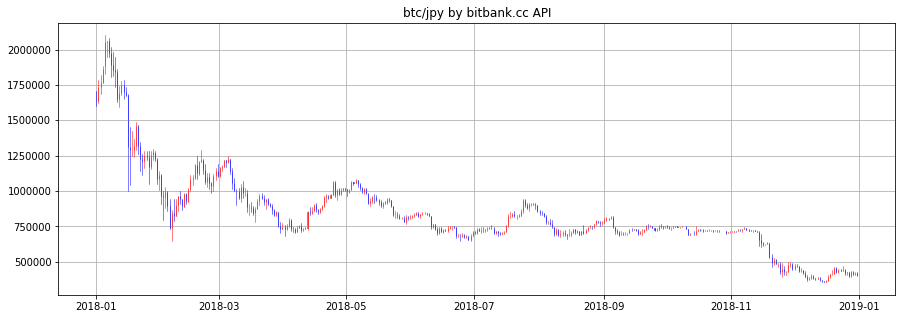

In [15]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
mpl_finance.candlestick_ohlc(ax, data, width=0.01, alpha=0.5, colorup='r', colordown='b')
ax.grid()
locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
plt.title('btc/jpy by bitbank.cc API')